STEP - 1 DATA EXPLORATION AND PREPROCESSING

In [1]:
# Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
data = pd.read_csv('Original_dataset.csv')

In [26]:
 # data.head()

In [7]:
data.shape

(95837, 23)

In [42]:
#list(data.columns) # View the coloumns

In [28]:
# data.info() # To know the datatypes

In [10]:
data.duplicated().sum() # To check the Duplicates

np.int64(0)

In [29]:
# data.isnull().sum()  # To check the Missing values

In [ ]:
# To drop unnecessary coloumns
data = data.drop(columns=["id_songs","release_date","id_artists","genres", "name_artists","name_song"], errors="ignore")


In [30]:
# data

In [ ]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

STEP - 2 FEATURE SELECTION


In [13]:
# STEP 2 — Feature Selection

# Recommended audio features for clustering
selected_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms"
]

# Select only these features from the cleaned dataset
data_features = data[selected_features]

# Normalization (Scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_features)


STEP - 3 DIMENSONALITY REDUCTION

In [15]:
# STEP 3 (Optional) — PCA for Visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

data_pca = pd.DataFrame(
    pca_components,
    columns=["PC1", "PC2"]
)

print("PCA Components (first 5 rows):")
print(data_pca.head())


PCA Components (first 5 rows):
        PC1       PC2
0 -1.676304  0.291571
1 -2.639968 -0.472803
2 -2.537328  0.474464
3 -0.677418  0.709757
4 -1.480657  1.426716


STEP - 4 CLUSTERING TECHNIQUES

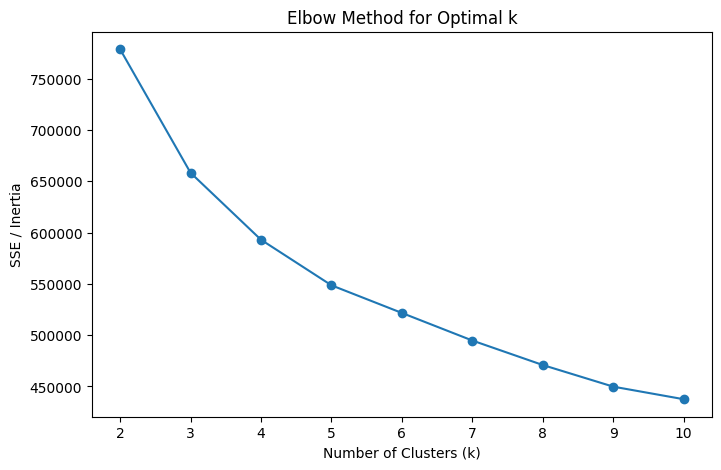

In [16]:
# find the best K using Elow Method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_range = range(2, 11)  # try 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE / Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [ ]:
# Validate the Clusters
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"k={k}, Silhouette Score={score}")


k=2, Silhouette Score=0.20317003588832863
k=3, Silhouette Score=0.2424014174066183
k=4, Silhouette Score=0.23106641264473726
k=5, Silhouette Score=0.1859687698010879
k=6, Silhouette Score=0.18645788196186036
k=7, Silhouette Score=0.16496429351963174
k=8, Silhouette Score=0.17213999329059596
k=9, Silhouette Score=0.17223407836437804
k=10, Silhouette Score=0.15930873372490909


In [17]:
# Apply K Means with Best K
best_k = 3

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to original dataset
data["cluster"] = cluster_labels



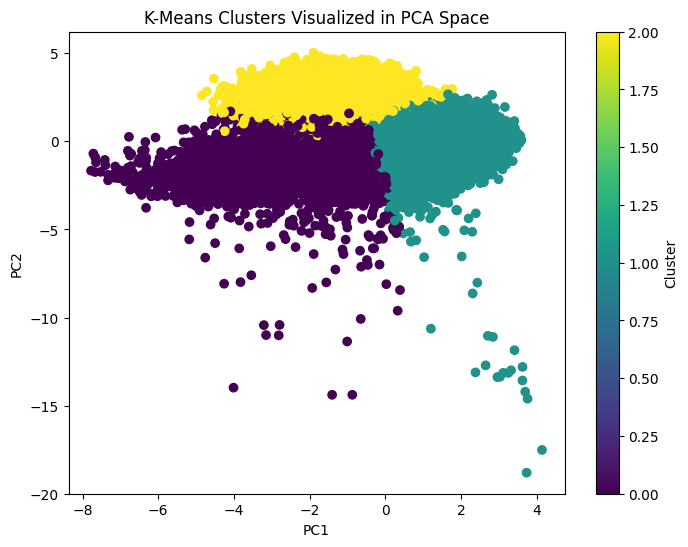

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(data_pca["PC1"], data_pca["PC2"], c=cluster_labels, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters Visualized in PCA Space")
plt.colorbar(label="Cluster")
plt.show()


STEP 5 CLUSTER EVALUATION AND INTERPRETATION

In [19]:
# Davies–Bouldin Index (DBI)
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(scaled_data, cluster_labels)
print("Davies-Bouldin Index:", dbi)


Davies-Bouldin Index: 1.5699416879877057


In [20]:
# Inertia
print("K-Means Inertia:", kmeans.inertia_)

K-Means Inertia: 658335.9621683044


In [22]:
# Mean value of all audio features
cluster_profile = data.groupby("cluster")[selected_features].mean()
cluster_profile


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
cluster,,,,,,,,,,
0,0.486242,0.311018,-13.208988,0.060103,0.749539,0.168760,0.182065,0.413047,111.933323,223500.904818
1,0.627309,0.693465,-7.608616,0.075061,0.258713,0.050681,0.199854,0.666324,124.905464,226568.204680
2,0.664254,0.466617,-13.364383,0.829908,0.585922,0.001384,0.435498,0.584036,100.387090,97522.338234


In [23]:
# Automatically Assign Descriptions

data["cluster_label"] = data["cluster"].map({
    0: "High Energy / Party",
    1: "Chill Acoustic",
    2: "Emotional / Instrumental"
})



In [25]:
# data['cluster_label']

STEP - 6 VISUALISATION

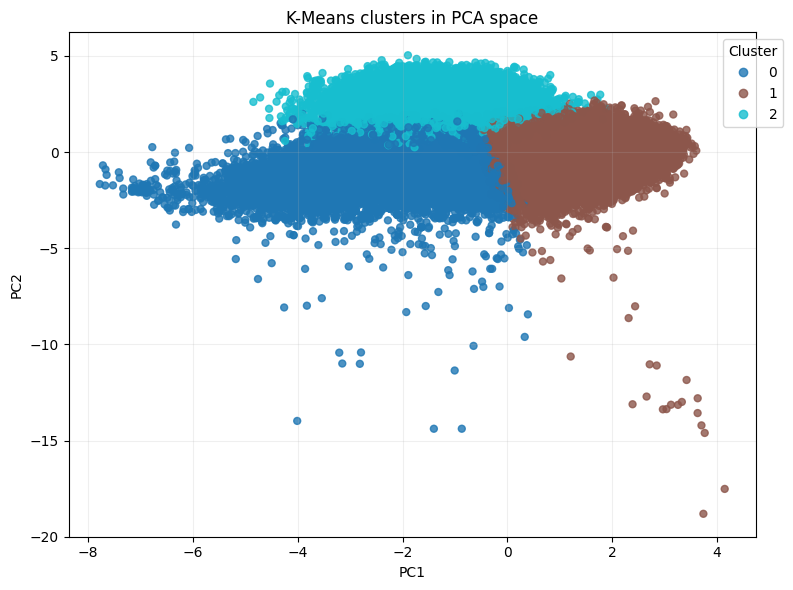

In [31]:
# PCA 2D Scatter plot

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
scatter = plt.scatter(data_pca["PC1"], data_pca["PC2"],
                      c=cluster_labels, cmap="tab10", s=25, alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means clusters in PCA space")
plt.legend(*scatter.legend_elements(), title="Cluster", bbox_to_anchor=(1.05,1))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

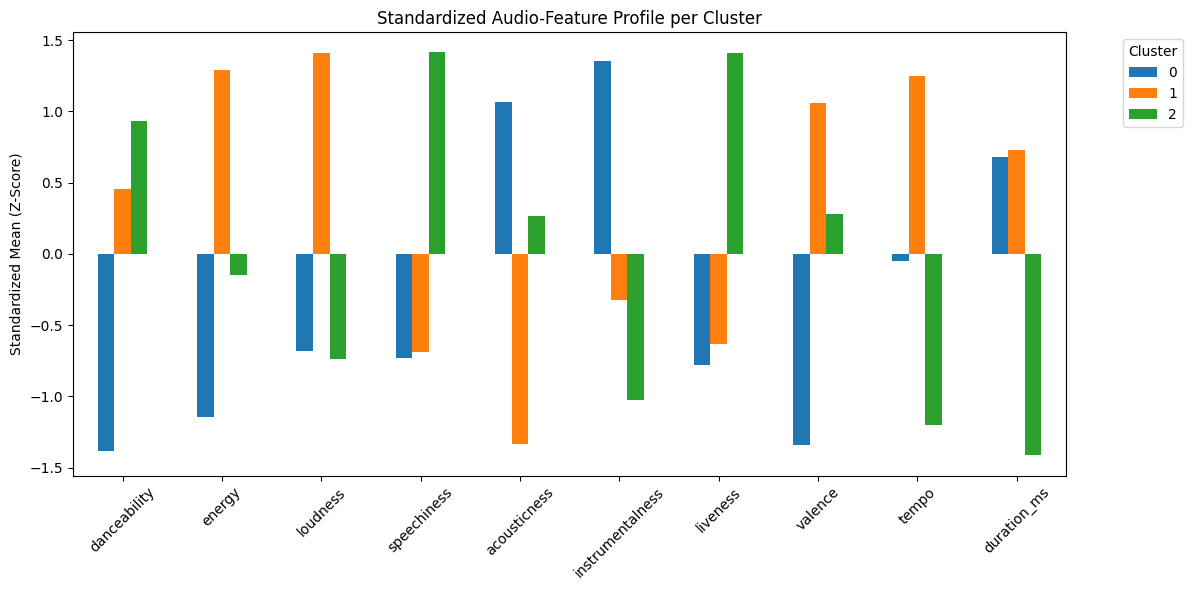

In [34]:
# Average Feature per Cluster

# ================================
# 1. Import Libraries
# ================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ================================
# 2. Create Cluster Profile (Mean Feature Values Per Cluster)
#    data_features = your 10 selected audio features
#    cluster_labels = from KMeans
# ================================
profile = pd.concat([
    data_features.reset_index(drop=True),
    pd.Series(cluster_labels, name="cluster")
], axis=1).groupby("cluster").mean()

# ================================
# 3. Standardize (Z-Score) for Visualization
#    Standardize each feature across clusters
# ================================
scaler = StandardScaler()
profile_z = pd.DataFrame(
    scaler.fit_transform(profile),
    columns=profile.columns,
    index=profile.index
)

# Transpose so features appear on X-axis
profile_z_T = profile_z.T

# ================================
# 4. Bar Chart (Standardized Values)
# ================================
plt.figure(figsize=(12,6))
profile_z_T.plot(kind="bar", rot=45, figsize=(12,6))
plt.title("Standardized Audio-Feature Profile per Cluster")
plt.ylabel("Standardized Mean (Z-Score)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


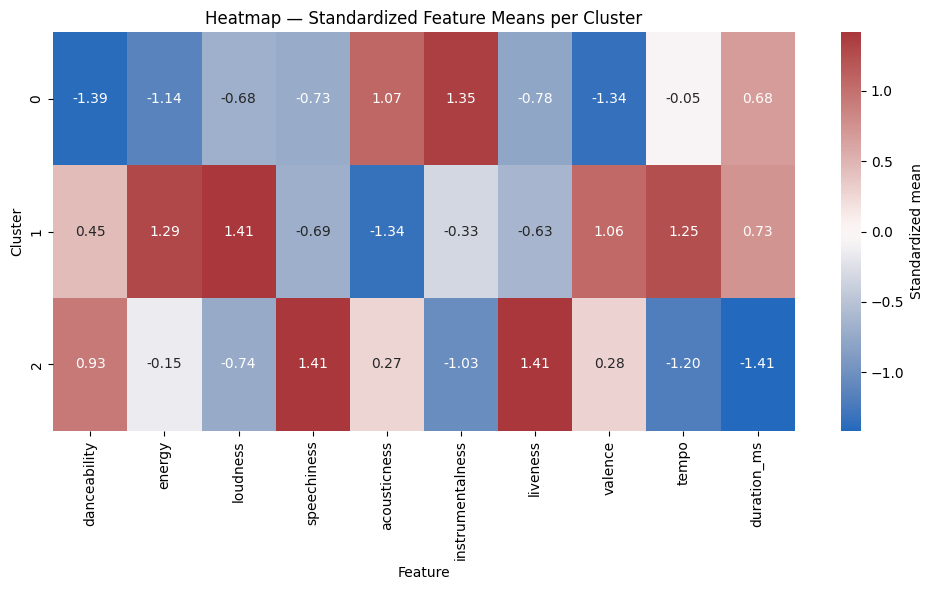

In [36]:
# Features vs Clusters

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardize the cluster profile
scaler = StandardScaler()
profile_z = pd.DataFrame(
    scaler.fit_transform(profile),
    columns=profile.columns,
    index=profile.index
)

# Heatmap of standardized feature means
plt.figure(figsize=(10,6))
sns.heatmap(profile_z, annot=True, fmt=".2f", cmap="vlag", cbar_kws={"label": "Standardized mean"})
plt.title("Heatmap — Standardized Feature Means per Cluster")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()



/tmp/ipython-input-2498922830.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-2498922830.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipython-input-2498922830.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-2498922830.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipython-input-2498922830.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0

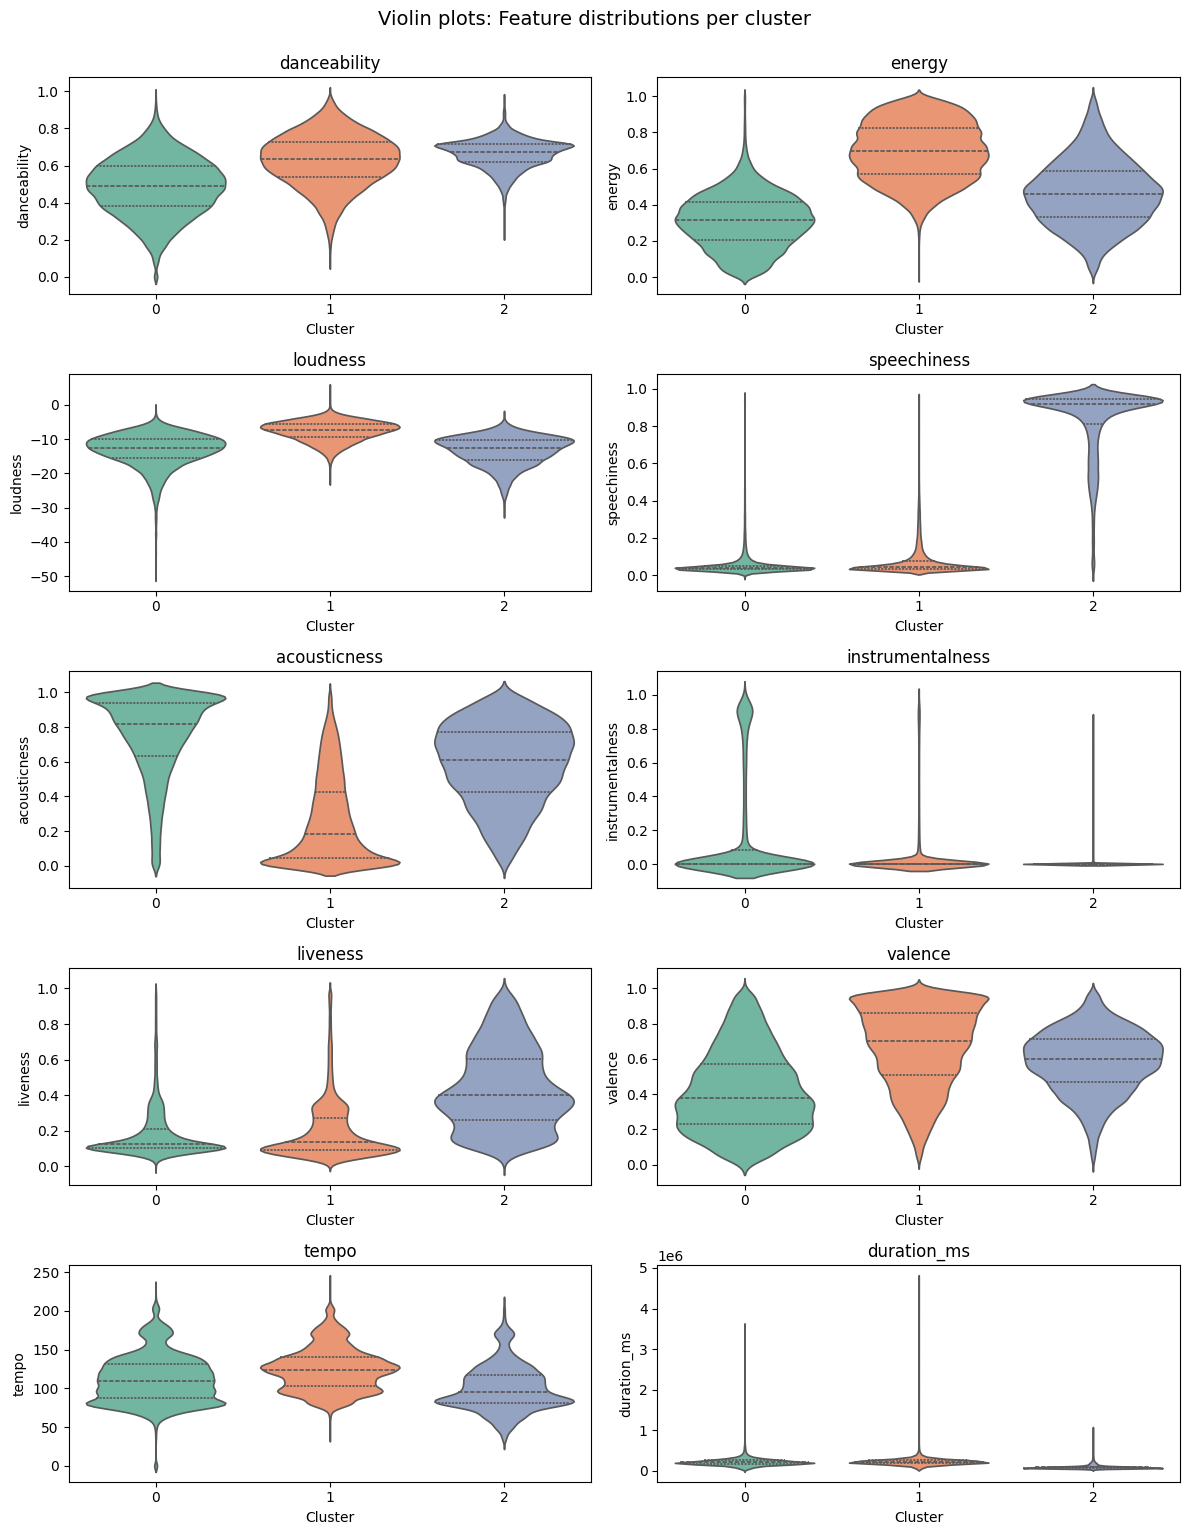

In [39]:
# Distribution plot for features like danceability....

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ensure cluster exists
if "cluster" not in data.columns:
    data = data.reset_index(drop=True).copy()
    data["cluster"] = pd.Series(cluster_labels, index=data.index)

features = data_features.columns.tolist()

# grid
n_cols = 2
n_rows = int(np.ceil(len(features)/n_cols))
plt.figure(figsize=(12, n_rows * 3))

for i, feat in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(
        x="cluster",
        y=feat,
        data=pd.concat([data[["cluster"]], data_features[feat]], axis=1),
        inner="quartile",
        scale="width",
        palette="Set2"     # <--- DIFFERENT COLORS FOR EACH CLUSTER
    )
    plt.title(feat)
    plt.xlabel("Cluster")
    plt.tight_layout()

plt.suptitle("Violin plots: Feature distributions per cluster", y=1.02, fontsize=14)
plt.show()


STEP 7 - FINAL ANALYSIS AND EXPORT

In [43]:
# ============================================================
# FINAL STEP 7 – Analysis, Export & Recommendations
# ============================================================

import pandas as pd
import numpy as np
from textwrap import dedent
import os

# ============================================================
# 1. Ensure cluster & cluster_label exist
# ============================================================

if "cluster" not in data.columns:
    data = data.reset_index(drop=True).copy()
    data["cluster"] = pd.Series(cluster_labels, index=data.index)

cluster_name_map = {
    0: "Calm_Acoustic",
    1: "Energetic_Pop_Party",
    2: "Vocal_Spoken_Live"
}

data["cluster_label"] = data["cluster"].map(cluster_name_map)

# ============================================================
# 2. Cluster Counts
# ============================================================

print("\nCluster Distribution:")
print(data["cluster_label"].value_counts())

# ============================================================
# 3. Cluster Profile (Feature Means)
# ============================================================

profile = data.groupby("cluster")[selected_features].mean()
print("\nCluster Profile (Means):")
print(profile)

# Save profile
profile.to_csv("cluster_profile_means.csv")
print("\nSaved: cluster_profile_means.csv")

# ============================================================
# 4. Top Tracks Per Cluster
# ============================================================

# Choose appropriate sort metric
if "popularity_songs" in data.columns:
    sort_metric = "popularity_songs"
elif "popularity_artists" in data.columns:
    sort_metric = "popularity_artists"
else:
    sort_metric = "energy"   # fallback

print(f"\nSorting top tracks using: {sort_metric}")

display_cols = [col for col in ["name_song", "name_artists", sort_metric] if col in data.columns]

# Folder for saving top tracks
os.makedirs("top_tracks_by_cluster", exist_ok=True)

top_n = 10

for c in sorted(data["cluster"].unique()):
    cluster_df = data[data["cluster"] == c].sort_values(sort_metric, ascending=False)
    top_df = cluster_df[display_cols].head(top_n).reset_index(drop=True)

    print(f"\nTop {top_n} Tracks — Cluster {c} ({cluster_name_map[c]}):")
    display(top_df)

    out_csv = f"top_tracks_by_cluster/top_tracks_cluster_{c}.csv"
    top_df.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv}")

# ============================================================
# 5. Export Final Dataset with Clusters
# ============================================================

final_csv = "music_with_clusters.csv"
data.to_csv(final_csv, index=False)
print(f"\nSaved final dataset: {final_csv}")

# ============================================================
# 6. Create Final Summary Report (WITH RECOMMENDATIONS)
# ============================================================

report_text = dedent(f"""
==========================================================
FINAL CLUSTERING REPORT – AMAZON MUSIC CLUSTERING PROJECT
==========================================================

Total Songs: {len(data)}
Selected Features: {selected_features}

----------------------------------------------------------
Cluster Distribution
----------------------------------------------------------
{data['cluster_label'].value_counts().to_string()}

----------------------------------------------------------
Cluster Profiles (Means)
----------------------------------------------------------
{profile.to_string()}

----------------------------------------------------------
Cluster Interpretations
----------------------------------------------------------

Cluster 0 – Calm_Acoustic
- Low energy, low danceability, slower tempo
- High acousticness
- Low valence
Interpretation: Calm, soft, low-energy acoustic songs ideal for relaxing, studying, sleeping, or background playlists.

Cluster 1 – Energetic_Pop_Party
- High energy, high tempo, high valence
- Low acousticness
Interpretation: Modern pop/dance songs suitable for workout, driving, party, and feel-good playlists.

Cluster 2 – Vocal_Spoken_Live
- Extremely high speechiness, high liveness
- Medium energy and tempo
- Low instrumentalness
Interpretation: Vocal-heavy, spoken-word, live performance, rap or podcast-style tracks.

----------------------------------------------------------
Business Recommendations
----------------------------------------------------------

1. Playlist Personalization:
   - Recommend Cluster 0 tracks to users who frequently listen to calm or acoustic music.
   - Recommend Cluster 1 tracks to users interested in upbeat, energetic playlists.
   - Recommend Cluster 2 tracks to listeners of podcasts, rap, or live sessions.

2. Automated Playlist Generation:
   - Build mood-based playlists (Relax, Party, Motivation, Live Sessions).
   - Use cluster labels to generate similar-song radio stations on the fly.

3. Improved Song Discovery:
   - Suggest "similar songs" by recommending tracks from the user’s dominant cluster.
   - Improve catalog search filters using cluster labels.

4. Artist Insights:
   - Identify which clusters certain artists frequently appear in.
   - Help streaming platforms categorize emerging artists based on sound style.

----------------------------------------------------------
Technical Recommendations
----------------------------------------------------------

1. Use cluster labels as additional features in recommendation engines.
2. Re-run clustering periodically as new songs enter the platform.
3. Use PCA or t-SNE visualization to monitor drift between clusters.
4. Optional: train a supervised model to predict cluster labels for new songs.

----------------------------------------------------------
Future Enhancements
----------------------------------------------------------

1. Add more audio features (e.g., MFCC, spectral contrast) from Spotify API.
2. Apply DBSCAN to identify noise/outlier songs.
3. Train a neural network autoencoder for deep embedding + clustering.
4. Analyze trends such as:
   - Most common cluster per year
   - Cluster-wise artist popularity
   - Genre distribution per cluster

----------------------------------------------------------
Saved Files
----------------------------------------------------------
- Full processed dataset: {final_csv}
- Cluster profiles: cluster_profile_means.csv
- Top tracks: top_tracks_by_cluster/*.csv
- Text report: clustering_report.txt

==========================================================
""").strip()


with open("clustering_report.txt", "w", encoding="utf-8") as f:
    f.write(report_text)

print("\nSaved: clustering_report.txt")
print("\n✔ Final analysis, export, and recommendations completed successfully.")




Cluster Distribution:
cluster_label
Energetic_Pop_Party    52560
Calm_Acoustic          30762
Vocal_Spoken_Live      12515
Name: count, dtype: int64

Cluster Profile (Means):
         danceability    energy   loudness  speechiness  acousticness  \
cluster                                                                 
0            0.486242  0.311018 -13.208988     0.060103      0.749539   
1            0.627309  0.693465  -7.608616     0.075061      0.258713   
2            0.664254  0.466617 -13.364383     0.829908      0.585922   

         instrumentalness  liveness   valence       tempo    duration_ms  
cluster                                                                   
0                0.168760  0.182065  0.413047  111.933323  223500.904818  
1                0.050681  0.199854  0.666324  124.905464  226568.204680  
2                0.001384  0.435498  0.584036  100.387090   97522.338234  

Saved: cluster_profile_means.csv

Sorting top tracks using: popularity_songs

Top 

,name_song,name_artists,popularity_songs
0,Arcade,Duncan Laurence,89
1,Put Your Records On,Ritt Momney,87
2,Hold On,Chord Overstreet,83
3,Arcade,Duncan Laurence,83
4,Go Fuck Yourself,Two Feet,80
5,Control,Zoe Wees,80
6,Beautiful Crazy,Luke Combs,80
7,ALL GIRLS ARE THE SAME,RØNIN,79
8,Blue Jeans,GANGGA,79
9,Weak,Larissa Lambert,79


Saved: top_tracks_by_cluster/top_tracks_cluster_0.csv

Top 10 Tracks — Cluster 1 (Energetic_Pop_Party):


,name_song,name_artists,popularity_songs
0,Astronaut In The Ocean,Masked Wolf,98
1,WITHOUT YOU,The Kid LAROI,94
2,Hecha Pa' Mi,Boza,92
3,911,Sech,91
4,What You Know Bout Love,Pop Smoke,91
5,Goosebumps,HVME,89
6,RAPSTAR,Polo G,89
7,Whoopty,CJ,89
8,Martin & Gina,Polo G,88
9,Tapão Na Raba,Raí Saia Rodada,87


Saved: top_tracks_by_cluster/top_tracks_cluster_1.csv

Top 10 Tracks — Cluster 2 (Vocal_Spoken_Live):


,name_song,name_artists,popularity_songs
0,Beautiful Pain (Losin My Mind),Polo G,72
1,Siempre Fine,Ak4:20,72
2,Neva Cared,Polo G,70
3,Gentleman,SL,70
4,The Chicken Wing Beat,Ricky Desktop,70
5,Ain't Nobody Takin My Baby,Russ,69
6,VIP in der Psychiatrie,K.I.Z,65
7,You Reposted in the Wrong Neighborhood I Glue7...,Shokk,63
8,Pot-Pourri: Temporal / Velocidade da Luz - Ao ...,Thiaguinho,63
9,Ella Se Arrebata,Ak4:20,63


Saved: top_tracks_by_cluster/top_tracks_cluster_2.csv

Saved final dataset: music_with_clusters.csv

Saved: clustering_report.txt

✔ Final analysis, export, and recommendations completed successfully.
